# Predicting the Beats-per-Minute of Songs
In this notebook, we will be predicting the beats-per-minute of songs based on the given dataset. You can find the competition and the dataset [here](https://www.kaggle.com/competitions/playground-series-s5e9).

<div align="center">
<img src="https://www.kaggle.com/competitions/91720/images/header" />
</div>

## 1. Importing Libraries

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import joblib
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import ExtraTreeRegressor, DecisionTreeRegressor
import lightgbm as lgb
import xgboost as xgb
from tqdm.notebook import tqdm
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

import warnings

### Configuration

In [2]:
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_style('darkgrid')

## 2. Loading Data

In [3]:
df = pd.read_csv('train.csv', index_col='id')

In [4]:
df.head()

,RhythmScore,AudioLoudness,VocalContent,AcousticQuality,InstrumentalScore,LivePerformanceLikelihood,MoodScore,TrackDurationMs,Energy,BeatsPerMinute
id,,,,,,,,,,
0,0.603610,-7.636942,0.023500,0.000005,0.000001,0.051385,0.409866,290715.6450,0.826267,147.53020
1,0.639451,-16.267598,0.071520,0.444929,0.349414,0.170522,0.651010,164519.5174,0.145400,136.15963
2,0.514538,-15.953575,0.110715,0.173699,0.453814,0.029576,0.423865,174495.5667,0.624667,55.31989
3,0.734463,-1.357000,0.052965,0.001651,0.159717,0.086366,0.278745,225567.4651,0.487467,147.91212
4,0.532968,-13.056437,0.023500,0.068687,0.000001,0.331345,0.477769,213960.6789,0.947333,89.58511


In [5]:
df.shape

(524164, 10)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 524164 entries, 0 to 524163
Data columns (total 10 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   RhythmScore                524164 non-null  float64
 1   AudioLoudness              524164 non-null  float64
 2   VocalContent               524164 non-null  float64
 3   AcousticQuality            524164 non-null  float64
 4   InstrumentalScore          524164 non-null  float64
 5   LivePerformanceLikelihood  524164 non-null  float64
 6   MoodScore                  524164 non-null  float64
 7   TrackDurationMs            524164 non-null  float64
 8   Energy                     524164 non-null  float64
 9   BeatsPerMinute             524164 non-null  float64
dtypes: float64(10)
memory usage: 44.0 MB


In [7]:
df.isnull().sum()

RhythmScore                  0
AudioLoudness                0
VocalContent                 0
AcousticQuality              0
InstrumentalScore            0
LivePerformanceLikelihood    0
MoodScore                    0
TrackDurationMs              0
Energy                       0
BeatsPerMinute               0
dtype: int64

In [8]:
df.duplicated().sum()

np.int64(0)

## 3. Exploratory Data Analysis

In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
RhythmScore,524164.0,0.632843,0.156899,0.076900,0.515850,0.634686,0.739179,0.975000
AudioLoudness,524164.0,-8.379014,4.616221,-27.509725,-11.551933,-8.252499,-4.912298,-1.357000
VocalContent,524164.0,0.074443,0.049939,0.023500,0.023500,0.066425,0.107343,0.256401
AcousticQuality,524164.0,0.262913,0.223120,0.000005,0.069413,0.242502,0.396957,0.995000
InstrumentalScore,524164.0,0.117690,0.131845,0.000001,0.000001,0.074247,0.204065,0.869258
LivePerformanceLikelihood,524164.0,0.178398,0.118186,0.024300,0.077637,0.166327,0.268946,0.599924
MoodScore,524164.0,0.555843,0.225480,0.025600,0.403921,0.564817,0.716633,0.978000
TrackDurationMs,524164.0,241903.692949,59326.601501,63973.000000,207099.876625,243684.058150,281851.658500,464723.228100
Energy,524164.0,0.500923,0.289952,0.000067,0.254933,0.511800,0.746000,1.000000
BeatsPerMinute,524164.0,119.034899,26.468077,46.718000,101.070410,118.747660,136.686590,206.037000


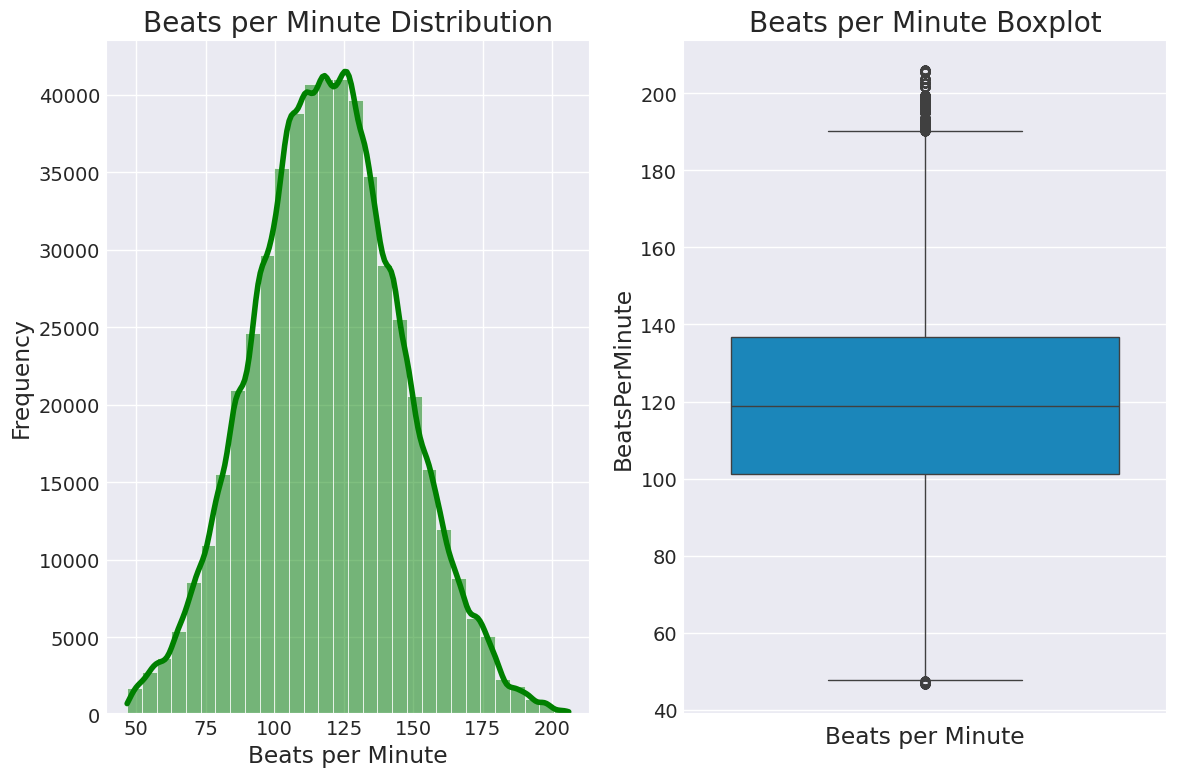

In [10]:
plt.subplot(1, 2, 1)
sns.histplot(df['BeatsPerMinute'], bins=30, kde=True, color='g')
plt.title('Beats per Minute Distribution')
plt.xlabel('Beats per Minute')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.boxplot(df['BeatsPerMinute'])
plt.title('Beats per Minute Boxplot')
plt.xlabel('Beats per Minute')

plt.tight_layout()

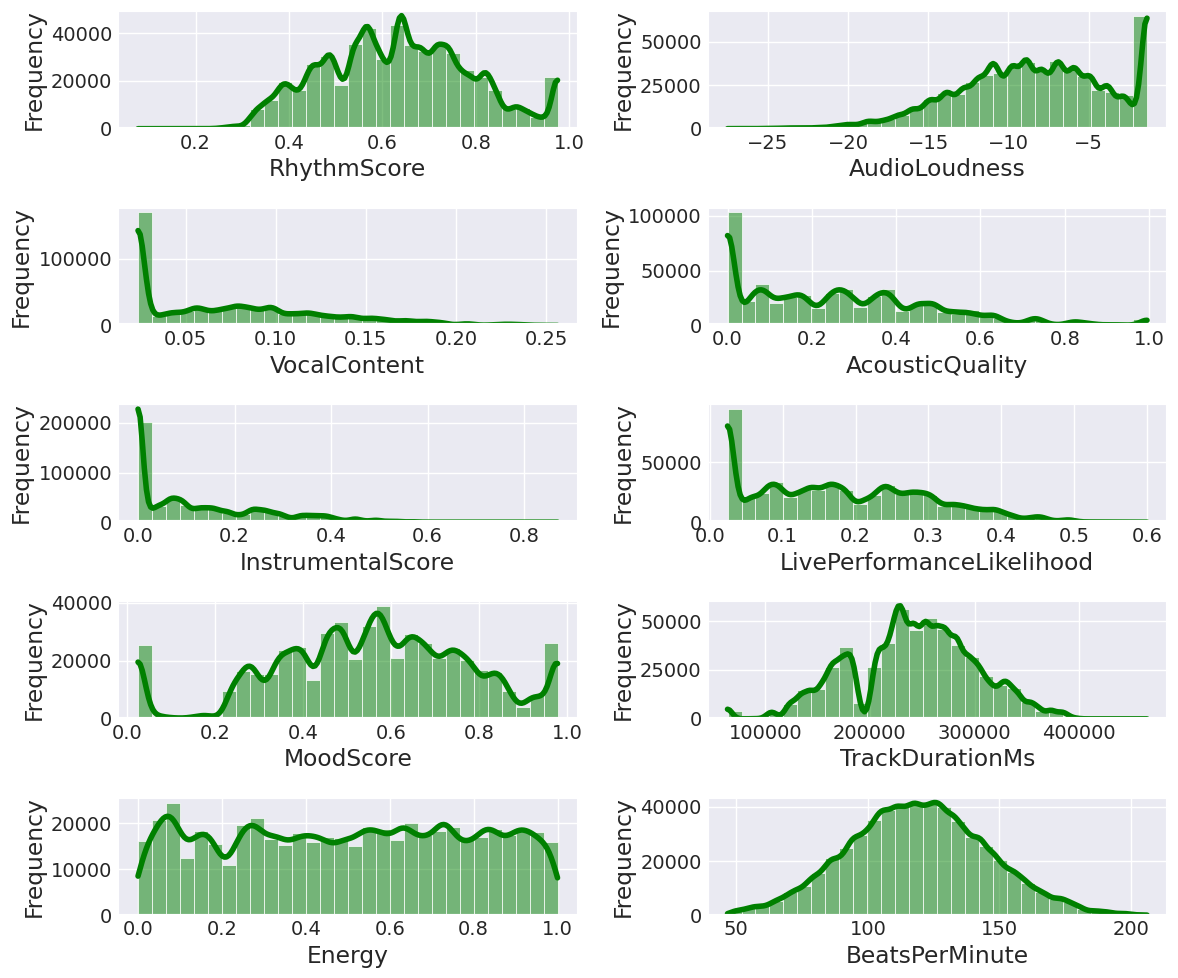

In [11]:
# All features histplot
plt.figure(figsize=(12, 10))
for i, feature in enumerate(df.columns):
    plt.subplot(5, 2, i + 1)
    sns.histplot(df[feature], bins=30, kde=True, color='g')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
plt.tight_layout()

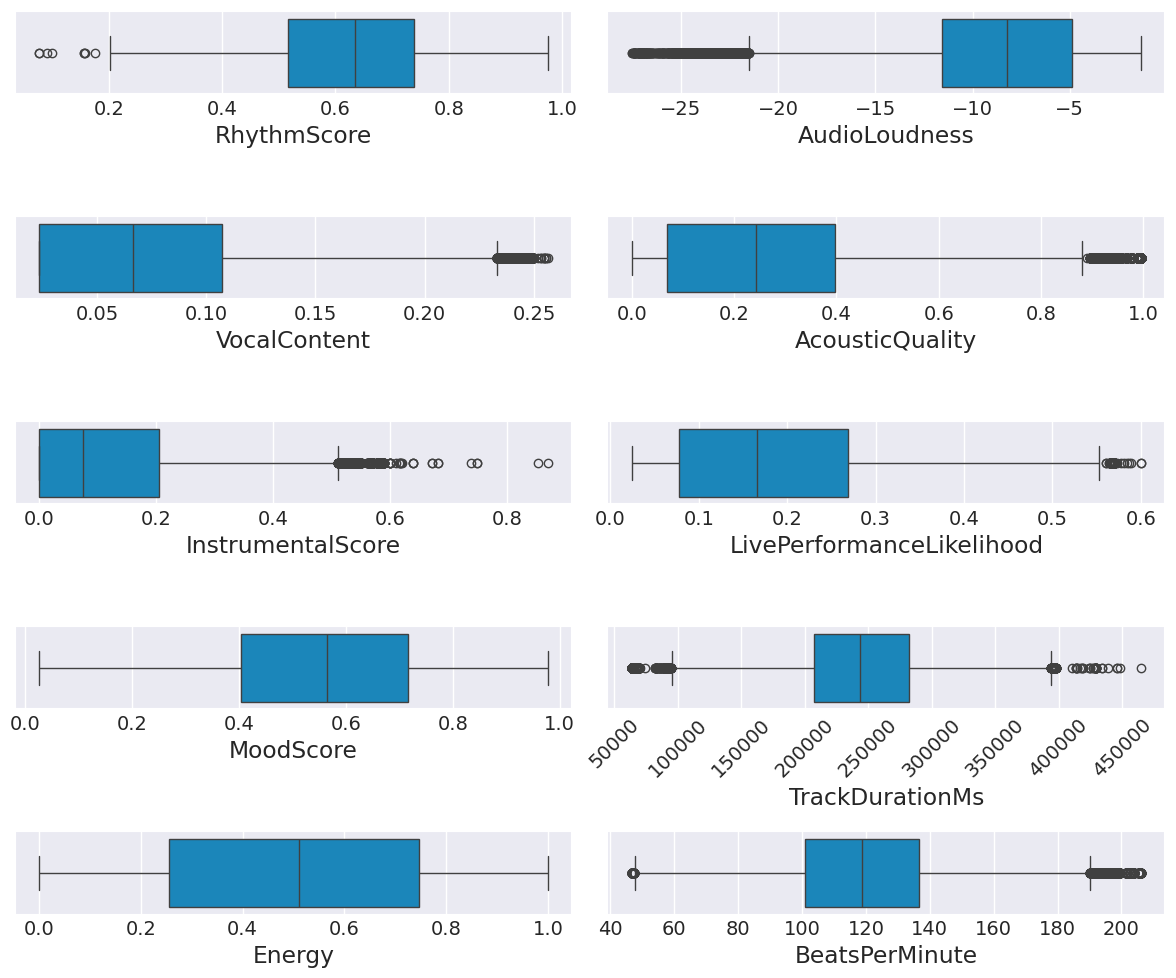

In [12]:
# All features boxplot
plt.figure(figsize=(12, 10))
for i, feature in enumerate(df.columns):
    plt.subplot(5, 2, i + 1)
    sns.boxplot(df[feature], orient='h')
    if feature == 'TrackDurationMs':
        plt.xticks(rotation=45)
plt.tight_layout()

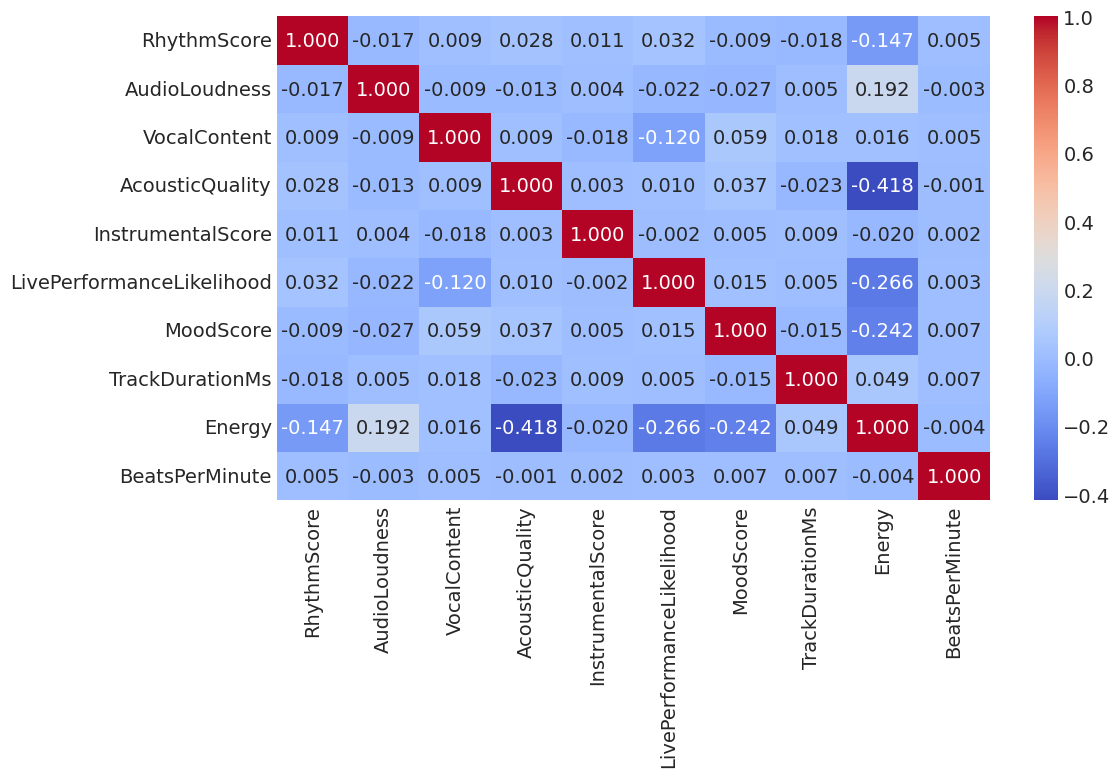

In [13]:
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.3f')
plt.tight_layout()

In [14]:
df.corr()['BeatsPerMinute'].sort_values(ascending=False)

BeatsPerMinute               1.000000
MoodScore                    0.007059
TrackDurationMs              0.006637
RhythmScore                  0.005440
VocalContent                 0.004876
LivePerformanceLikelihood    0.003471
InstrumentalScore            0.001900
AcousticQuality             -0.000820
AudioLoudness               -0.003327
Energy                      -0.004375
Name: BeatsPerMinute, dtype: float64

## 4. Data Preprocessing

In [15]:
x = df.drop(columns=['BeatsPerMinute'])
y = df[['BeatsPerMinute']]

In [16]:
scaler = MinMaxScaler()
x_scaled = scaler.fit_transform(x)

In [17]:
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.2, random_state=42)

## 5. Model Training

In [18]:
models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "DecisionTreeRegressor": DecisionTreeRegressor(),
    "ExtraTreeRegressor": ExtraTreeRegressor(),
    "LightGBM": lgb.LGBMRegressor(verbose=-1),
    "XGBoost": xgb.XGBRegressor()
}

def evaluate(x_train, y_train, x_test, y_test):
    results = []
    for name, model in tqdm(models.items()):
        print(f"Training {name} model...")
        y_pred = model.fit(x_train, y_train).predict(x_test)
        
        results.append({
            "Model": name,
            "R2_Score": r2_score(y_test, y_pred),
            "MSE": mean_squared_error(y_test, y_pred),
            "RMSE": mean_squared_error(y_test, y_pred)**0.5
        })
    report = pd.DataFrame(results).sort_values('R2_Score', ascending=False)
    report.reset_index(drop=True, inplace=True)
    return report

In [19]:
evaluate(x_train, y_train, x_test, y_test)

  0%|          | 0/7 [00:00<?, ?it/s]

Training LinearRegression model...
Training Ridge model...
Training Lasso model...
Training DecisionTreeRegressor model...
Training ExtraTreeRegressor model...
Training LightGBM model...
Training XGBoost model...


,Model,R2_Score,MSE,RMSE
0,LightGBM,0.000270,699.156319,26.441564
1,Ridge,0.000095,699.278780,26.443880
2,LinearRegression,0.000095,699.278781,26.443880
3,Lasso,-0.000017,699.356912,26.445357
4,XGBoost,-0.009093,705.704285,26.565095
5,DecisionTreeRegressor,-1.098213,1467.375428,38.306337
6,ExtraTreeRegressor,-1.132280,1491.199887,38.616057


### Hyperparameter Tuning

In [20]:
# Hyperparameters for grid search
param_grid = {
    'num_leaves': [31, 50, 100],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [50, 100, 500],
    'max_depth': [3, 5],
}

In [21]:
%%time
grid_search = GridSearchCV(
    estimator=lgb.LGBMRegressor(verbose=-1),
    param_grid=param_grid,
    cv=5,
    scoring='r2'
)
grid_search.fit(x_train, y_train)

CPU times: user 30min 54s, sys: 3.71 s, total: 30min 57s
Wall time: 7min 51s


,estimator,LGBMRegressor(verbose=-1)
,param_grid,"{'learning_rate': [0.01, 0.05, ...], 'max_depth': [3, 5], 'n_estimators': [50, 100, ...], 'num_leaves': [31, 50, ...]}"
,scoring,'r2'
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,boosting_type,'gbdt'


In [22]:
grid_search.best_params_

{'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500, 'num_leaves': 31}

In [23]:
grid_search.best_score_

np.float64(0.0005613673684184084)

## 6. Build Pipeline with the best model, Save the model, Make Submission

In [24]:
preprocessor = ColumnTransformer([
    ('scaler', MinMaxScaler(), x.columns)
])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', lgb.LGBMRegressor(verbose=-1, **grid_search.best_params_))
])

In [25]:
pipeline.fit(x, y)

,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('scaler', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [26]:
y_pred = pipeline.predict(x)

print(f"R2 Score : {r2_score(y, y_pred)}")
print(f"MSE      : {mean_squared_error(y, y_pred)}")
print(f"RMSE     : {mean_squared_error(y, y_pred)**0.5}")

R2 Score : 0.0013954646069392895
MSE      : 699.5801712038614
RMSE     : 26.44957790218705


In [28]:
joblib.dump(pipeline, 'bpm_pipeline.pkl')

['bpm_pipeline.pkl']

In [29]:
test = pd.read_csv('test.csv', index_col='id')
predictions = pipeline.predict(test)

submission = pd.DataFrame({
    'id': test.index,
    'BeatsPerMinute': predictions
})
submission.head()

,id,BeatsPerMinute
0,524164,119.251660
1,524165,118.677528
2,524166,119.200086
3,524167,119.332576
4,524168,119.371605


In [30]:
submission.to_csv('submission.csv', index=False)

## 7. Conclusion
This notebook successfully built a machine learning pipeline to predict song BPM using various regression models. `LightGBM` emerged as the best performer after hyperparameter tuning, achieving optimal results through grid search. The final pipeline includes data preprocessing with MinMaxScaler and the tuned LightGBM model, which was saved for future use and used to generate predictions for the test set.